In [1]:

import os
import pandas as pd
import numpy as np
from scipy.io import loadmat  # To read .mat files
from scipy.signal import welch # For signal analysis (power spectral density)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

#Our file path
mat_file_path = "C:/Design Creativity EEG Dataset in Loosely Controlled Modified TTCT-F Creativity Experiments/Creativity_EEG_Dataset/Data_Creativity_Sub_1.mat"
data = loadmat(mat_file_path)

print("MAT file keys:", data.keys())

#In our data every key has numpy array inside, shape is (63, N). 63 channel, N time sample.
#We processed IDE, IDG and IDR keys.

task_keys = [k for k in data.keys() if ('IDE' in k or 'IDG' in k or 'IDR' in k)]
print("Found task keys:", task_keys)

MAT file keys: dict_keys(['__header__', '__version__', '__globals__', 'Creativity_1_1_IDE', 'Creativity_1_1_IDG', 'Creativity_1_1_IDR', 'Creativity_1_2_IDE', 'Creativity_1_2_IDG', 'Creativity_1_2_IDR', 'Creativity_1_3_IDE', 'Creativity_1_3_IDG', 'Creativity_1_3_IDR', 'Creativity_1_RST1', 'Creativity_1_RST2'])
Found task keys: ['Creativity_1_1_IDE', 'Creativity_1_1_IDG', 'Creativity_1_1_IDR', 'Creativity_1_2_IDE', 'Creativity_1_2_IDG', 'Creativity_1_2_IDR', 'Creativity_1_3_IDE', 'Creativity_1_3_IDG', 'Creativity_1_3_IDR']


In [2]:
def segment_data(data_array, window_size=1000, step_size=1000):
#Split the EEG data into small parts (segments)
    num_channels, num_samples = data_array.shape  
    segments = [] # List to store small parts
    start = 0

#Loop to split the data
    while start + window_size <= num_samples:
        segment = data_array[:, start:start+window_size]
        segments.append(segment)
        start += step_size
#Return all small parts as an array
    return np.array(segments)  # shape: (num_segments, num_channels, window_size)

In [3]:
#This function will calculate the power in a frequency band.
def bandpower(psd, freqs, band):
    fmin, fmax = band
    idx = np.logical_and(freqs >= fmin, freqs <= fmax)
    return np.trapz(psd[idx], freqs[idx])

def extract_features(segment, fs=500):
# This function will calculate features for EEG data.
    # Bands: Delta(1-4), Theta(4-8), Alpha(8-13), Beta(13-30)
    bands = {
        'delta': (1,4),
        'theta': (4,8),
        'alpha': (8,13),
        'beta': (13,30)
    }
    num_channels = segment.shape[0]
    features = []
    
     # Loop through each channel
    for ch in range(num_channels):
        f, pxx = welch(segment[ch,:], fs=fs, nperseg=250)
        ch_feats = []

         # Loop through each frequency band
        for bname, brange in bands.items(): 
            bp = bandpower(pxx, f, brange) # Calculate power for the band
            ch_feats.append(bp) # Add power to features
        features.extend(ch_feats)   # Add channel features to total features
    return np.array(features)

In [6]:

all_features = []
all_labels = []

#Window size: 2 seconds * 500 Hz = 1000 points (example), we use 250 points
window_size = 250
step_size = 250 # Move this many points to next window

# Loop all task keys (IDE, IDG, IDR)
for tk in task_keys:
    eeg_data = data[tk]  # (63 channels , N time samples)

    # Split the data into small parts
    segments = segment_data(eeg_data, window_size=window_size, step_size=step_size)
    # Find the task name from file name
    task = tk.split('_')[-1]

     # Loop through all segments
    for seg in segments:
        feat = extract_features(seg, fs=500)
        all_features.append(feat)
        all_labels.append(task)


# Define frequency bands: delta, theta, alpha, beta 
bands = ['delta','theta','alpha','beta']
feature_names = []

# We have looped through all channels and bands (63*4 = 252 features we have totally)
for ch in range(63):
    for band_name in bands:
        feature_names.append(f'ch{ch+1}_{band_name}_power')

# Create a DataFrame to store features and labels
final_df = pd.DataFrame(all_features, columns=feature_names)
final_df['label'] = all_labels

print("Final feature DataFrame shape:", final_df.shape)
print(final_df.head())

C:\Users\2100005539\AppData\Local\Temp\ipykernel_34116\3130333000.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[idx], freqs[idx])


Final feature DataFrame shape: (1988, 253)
   ch1_delta_power  ch1_theta_power  ch1_alpha_power  ch1_beta_power  \
0     2.909573e-07     8.904139e-07     2.603487e-07        0.000002   
1     2.486160e-07     7.953357e-08     2.722574e-07        0.000002   
2     3.336999e-07     2.477260e-07     4.403816e-07        0.000002   
3     8.873480e-07     1.025497e-06     5.389456e-07        0.000002   
4     3.477289e-07     1.329564e-06     9.150692e-07        0.000001   

   ch2_delta_power  ch2_theta_power  ch2_alpha_power  ch2_beta_power  \
0     6.595330e-08     1.493466e-07     2.173391e-07    3.038327e-07   
1     8.141899e-08     4.812668e-07     2.221388e-07    7.859383e-07   
2     9.192804e-08     1.801543e-07     1.489477e-07    5.194696e-07   
3     3.610381e-08     1.433884e-07     4.741291e-08    3.099492e-07   
4     6.919206e-08     1.204243e-07     5.842237e-08    3.498594e-07   

   ch3_delta_power  ch3_theta_power  ...  ch61_beta_power  ch62_delta_power  \
0     5.1750

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Describe numerical features
print(final_df['label'].value_counts())
desc = final_df.drop('label', axis=1).describe()
print(desc)


label
IDE    3897
IDG    2270
IDR     692
Name: count, dtype: int64
       ch1_delta_power  ch1_theta_power  ch1_alpha_power  ch1_beta_power  \
count     6.859000e+03     6.859000e+03     6.859000e+03    6.859000e+03   
mean      5.805007e-07     7.584520e-07     6.652124e-07    1.633016e-06   
std       1.140558e-06     1.514849e-06     9.142678e-07    1.088066e-06   
min       3.758248e-08     7.973950e-08     5.831069e-08    3.579810e-07   
25%       2.137179e-07     3.038154e-07     3.372171e-07    1.029603e-06   
50%       3.053509e-07     4.114818e-07     4.568401e-07    1.371073e-06   
75%       4.587863e-07     5.890959e-07     6.313016e-07    1.816495e-06   
max       1.189265e-05     1.849072e-05     1.186790e-05    9.518165e-06   

       ch2_delta_power  ch2_theta_power  ch2_alpha_power  ch2_beta_power  \
count     6.859000e+03     6.859000e+03     6.859000e+03    6.859000e+03   
mean      1.101541e-07     1.593278e-07     1.607121e-07    4.301061e-07   
std       1.127897e

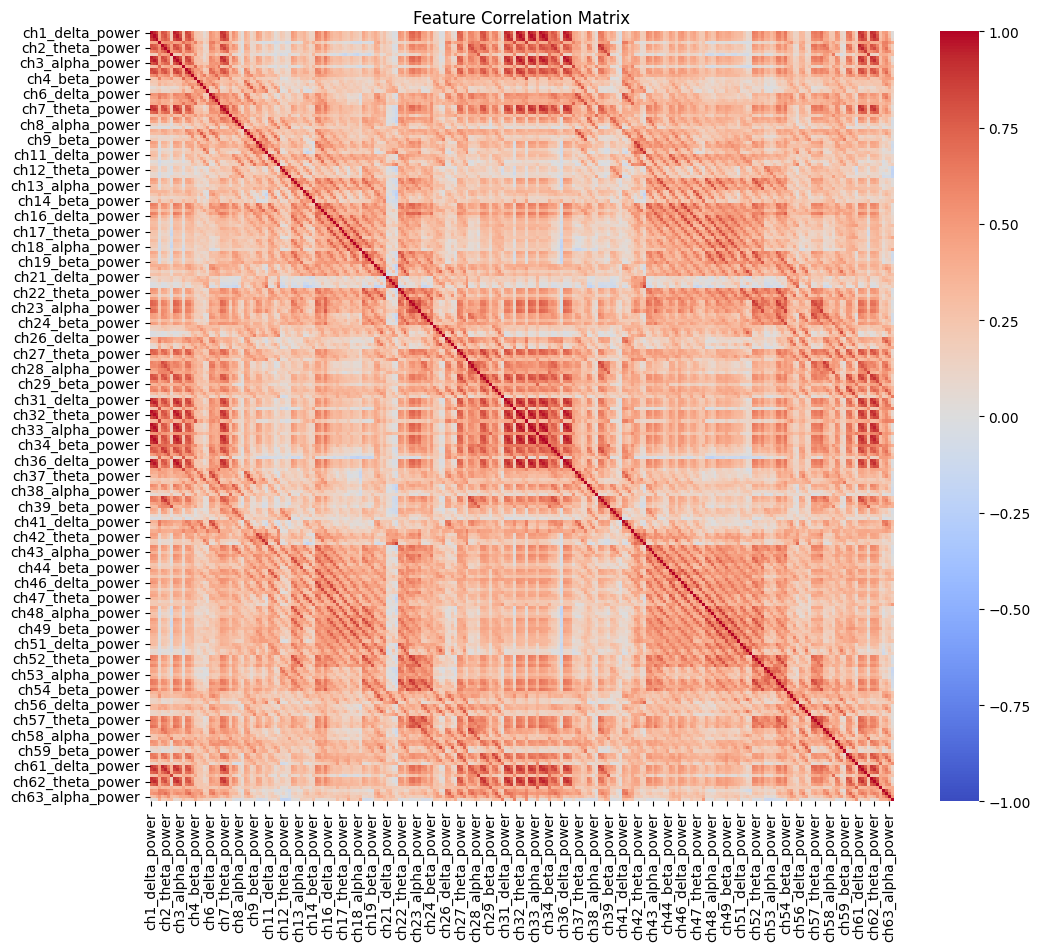

In [44]:
# Remove 'label' column and calculate correlation between features
corr_matrix = final_df.drop('label', axis=1).corr() # Find correlations for all features
plt.figure(figsize=(12, 10)) 

# Create a heatmap to show the correlation matrix
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1.0, vmin=-1.0)
plt.title("Feature Correlation Matrix")
plt.show()


In [45]:
# Select 'ch1_alpha_power' values for each task (IDE, IDG, IDR)
IDE_values = final_df.loc[final_df['label'] == 'IDE', 'ch1_alpha_power']
IDG_values = final_df.loc[final_df['label'] == 'IDG', 'ch1_alpha_power']
IDR_values = final_df.loc[final_df['label'] == 'IDR', 'ch1_alpha_power']

# ANOVA testi
f_stat, p_value = stats.f_oneway(IDE_values, IDG_values, IDR_values)
print("ANOVA sonuçları (ch1_alpha_power): F-stat=", f_stat, ", p-value=", p_value)

if p_value < 0.05:
    print("p<0.05: Gruplar arasında istatistiksel olarak anlamlı fark var.")
else:
    print("p>=0.05: Gruplar arasında anlamlı fark yok.")


ANOVA sonuçları (ch1_alpha_power): F-stat= 32.401811966065004 , p-value= 9.866438164114786e-15
p<0.05: Gruplar arasında istatistiksel olarak anlamlı fark var.


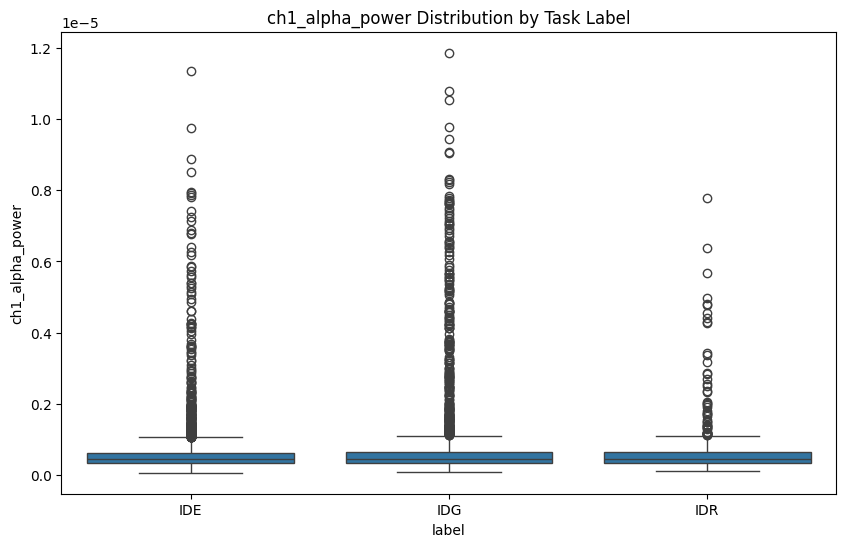

In [47]:
plt.figure(figsize=(10,6))
sns.boxplot(x='label', y='ch1_alpha_power', data=final_df)
plt.title("ch1_alpha_power Distribution by Task Label")
plt.show()


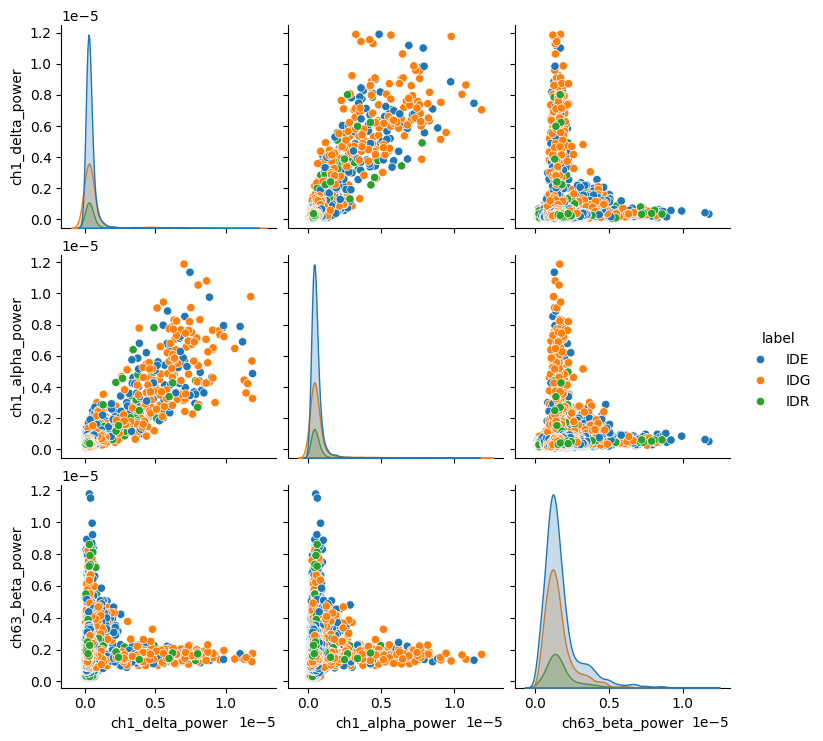

In [48]:
# Select a few features and the label column for the plot
subset_features = ['ch1_delta_power', 'ch1_alpha_power', 'ch63_beta_power', 'label']

#Create a pairplot to show relationships between features
sns.pairplot(final_df[subset_features], hue='label', diag_kind='kde')
plt.show()


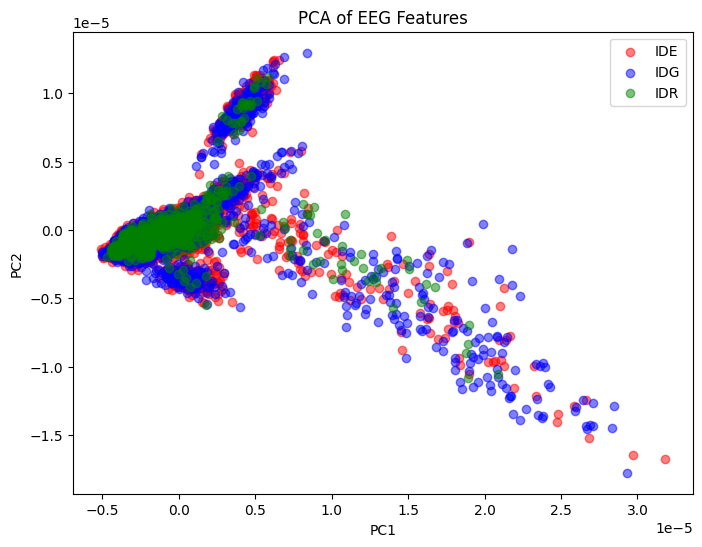

In [49]:
from sklearn.decomposition import PCA

# Remove the label column to only use features
X_features = final_df.drop('label', axis=1)

# Apply PCA to reduce features to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_features)

plt.figure(figsize=(8,6))

# Loop through labels 
for l, c in zip(['IDE','IDG','IDR'], ['red','blue','green']):
    plt.scatter(X_pca[final_df['label']==l, 0], X_pca[final_df['label']==l, 1], alpha=0.5, label=l, c=c)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of EEG Features")
plt.legend()
plt.show()


In [9]:
#Drop label it will be target
X = final_df.drop('label', axis=1)
y = final_df['label']

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model using scaled training data
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[703  77   0]
 [329 125   0]
 [115  22   1]]

Classification Report:
              precision    recall  f1-score   support

         IDE       0.61      0.90      0.73       780
         IDG       0.56      0.28      0.37       454
         IDR       1.00      0.01      0.01       138

    accuracy                           0.60      1372
   macro avg       0.72      0.39      0.37      1372
weighted avg       0.63      0.60      0.54      1372



In [8]:
import os
import pandas as pd
import numpy as np
from scipy.io import loadmat  # To read .mat files
from scipy.signal import welch # For signal analysis (power spectral density)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# We find all .mat files in the directory
data_dir = "C:/Design Creativity EEG Dataset in Loosely Controlled Modified TTCT-F Creativity Experiments/Creativity_EEG_Dataset/"
# List all files that end with .mat
subjects = [f for f in os.listdir(data_dir) if f.endswith('.mat')]

print("Found subjects:", subjects)

#Parameters
fs = 500  # Sampling rate
window_size = 1000  # 2 second view
step_size = 1000
bands = {
    'delta': (1,4),
    'theta': (4,8),
    'alpha': (8,13),
    'beta': (13,30)
}

def segment_data(data_array, window_size=1000, step_size=1000):
    num_channels, num_samples = data_array.shape
    segments = []
    start = 0
    while start + window_size <= num_samples:
        segment = data_array[:, start:start+window_size]
        segments.append(segment)
        start += step_size
    return np.array(segments)

def bandpower(psd, freqs, band):
    fmin, fmax = band
    idx = np.logical_and(freqs >= fmin, freqs <= fmax)
    return np.trapz(psd[idx], freqs[idx])

def extract_features(segment, fs=500):
    num_channels = segment.shape[0]
    features = []
    for ch in range(num_channels):
        f, pxx = welch(segment[ch,:], fs=fs, nperseg=250)
        ch_feats = []
        for bname, brange in bands.items():
            bp = bandpower(pxx, f, brange)
            ch_feats.append(bp)
        features.extend(ch_feats)
    return np.array(features)

#Lists for all datas
all_features = []
all_labels = []

for subj_file in subjects:
    mat_path = os.path.join(data_dir, subj_file)
    data = loadmat(mat_path)
    
    # Check task keys in .mat files
    task_keys = [k for k in data.keys() if ('IDE' in k or 'IDG' in k or 'IDR' in k)]
    
    for tk in task_keys:
        eeg_data = data[tk]  # (63, N) EEG array
        task = tk.split('_')[-1]  # Get tasks labels
        
        # Divide segments
        segments = segment_data(eeg_data, window_size=window_size, step_size=step_size)
        
        # Features for each segment
        for seg in segments:
            feat = extract_features(seg, fs=fs)
            all_features.append(feat)
            all_labels.append(task)

# 63 channel * 4 band = 252 features totally
feature_names = []
for ch in range(63):
    for bname in bands.keys():
        feature_names.append(f'ch{ch+1}_{bname}_power')

final_df = pd.DataFrame(all_features, columns=feature_names)
final_df['label'] = all_labels

print("Final combined DataFrame shape:", final_df.shape)
print(final_df['label'].value_counts())

Found subjects: ['Data_Creativity_Sub_1.mat', 'Data_Creativity_Sub_10.mat', 'Data_Creativity_Sub_11.mat', 'Data_Creativity_Sub_12.mat', 'Data_Creativity_Sub_13.mat', 'Data_Creativity_Sub_14.mat', 'Data_Creativity_Sub_15.mat', 'Data_Creativity_Sub_16.mat', 'Data_Creativity_Sub_17.mat', 'Data_Creativity_Sub_18.mat', 'Data_Creativity_Sub_19.mat', 'Data_Creativity_Sub_2.mat', 'Data_Creativity_Sub_20.mat', 'Data_Creativity_Sub_21.mat', 'Data_Creativity_Sub_22.mat', 'Data_Creativity_Sub_23.mat', 'Data_Creativity_Sub_24.mat', 'Data_Creativity_Sub_25.mat', 'Data_Creativity_Sub_26.mat', 'Data_Creativity_Sub_27.mat', 'Data_Creativity_Sub_28.mat', 'Data_Creativity_Sub_3.mat', 'Data_Creativity_Sub_4.mat', 'Data_Creativity_Sub_5.mat', 'Data_Creativity_Sub_6.mat', 'Data_Creativity_Sub_7.mat', 'Data_Creativity_Sub_8.mat', 'Data_Creativity_Sub_9.mat']


C:\Users\2100005539\AppData\Local\Temp\ipykernel_34116\3130333000.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[idx], freqs[idx])


Final combined DataFrame shape: (6859, 253)
label
IDE    3897
IDG    2270
IDR     692
Name: count, dtype: int64


In [10]:
#We see our data is unstable. To stabilize we tried different methods.
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Try Sampling Methods Function
def try_sampling_methods(X, y, sampling_method_name):
    if sampling_method_name == 'SMOTE':
        sampler = SMOTE(random_state=42)
    elif sampling_method_name == 'RandomOverSampler':
        sampler = RandomOverSampler(random_state=42)
    elif sampling_method_name == 'RandomUnderSampler':
        sampler = RandomUnderSampler(random_state=42)
    elif sampling_method_name == 'SMOTETomek':
        sampler = SMOTETomek(random_state=42)
    elif sampling_method_name == 'SMOTEENN':
        sampler = SMOTEENN(random_state=42)
    else:
        raise ValueError("Geçersiz sampling_method_name")
    
    # Stabilize data
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Model (Random Forest Classifier for each method)
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    model.fit(X_train_scaled, y_train)
    
    # Performance
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    return accuracy, report

# X ve y'yi ayarlayın (Mevcut veri setinizden)
# Örneğin:
# X = final_df.drop(columns=['label'])
# y = final_df['label']

# LabelEncoder to convert 'IDE', 'IDG', 'IDR' classes to 0,1,2
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Try and compare sampling methods.
sampling_methods = ['SMOTE', 'RandomOverSampler', 'RandomUnderSampler', 'SMOTETomek', 'SMOTEENN']

results = {}
for method in sampling_methods:
    print(f"\n{method} yöntemi uygulanıyor...")
    accuracy, report = try_sampling_methods(X, y_encoded, method)
    results[method] = accuracy
    print(f"Accuracy: {accuracy:.4f}")
    print(report)

best_method = max(results, key=results.get)
print(f"\nEn iyi yöntem: {best_method} ile {results[best_method]:.4f} doğruluk elde edildi.")



SMOTE yöntemi uygulanıyor...
Accuracy: 0.7888
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       802
           1       0.72      0.73      0.72       774
           2       0.92      0.96      0.94       763

    accuracy                           0.79      2339
   macro avg       0.79      0.79      0.79      2339
weighted avg       0.79      0.79      0.79      2339


RandomOverSampler yöntemi uygulanıyor...
Accuracy: 0.8576
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       802
           1       0.81      0.77      0.79       774
           2       0.98      0.99      0.99       763

    accuracy                           0.86      2339
   macro avg       0.86      0.86      0.86      2339
weighted avg       0.86      0.86      0.86      2339


RandomUnderSampler yöntemi uygulanıyor...
Accuracy: 0.4760
              precision    recall  f1-score   support

           0     

In [12]:
# We see the best method was RandomOverSampler, because the most stabilized data was in there and
# the highest support score was in there too. SMOTENN method was most succesfull method but its accuracy for IDE(0)
# class was too low. According this, we can say that best method is RandomOverSampler in RandomForestModel for this experiment.

from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

#RandomOverSampler
def try_random_oversampler(X, y):
    sampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    return accuracy, report

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

print("\nRandomOverSampler yöntemi uygulanıyor...")
accuracy, report = try_random_oversampler(X, y_encoded)
print(f"Accuracy: {accuracy:.4f}")
print(report)



RandomOverSampler yöntemi uygulanıyor...
Accuracy: 0.8576
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       802
           1       0.81      0.77      0.79       774
           2       0.98      0.99      0.99       763

    accuracy                           0.86      2339
   macro avg       0.86      0.86      0.86      2339
weighted avg       0.86      0.86      0.86      2339



In [20]:
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# SMOTEENN
def try_smoteenn_with_random_forest(X, y):
    sampler = SMOTEENN(random_state=42)
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    return accuracy, report

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

print("\nSMOTEENN yöntemi uygulanıyor")
accuracy, report = try_smoteenn_with_random_forest(X, y_encoded)
print(f"Accuracy: {accuracy:.4f}")
print(report)



SMOTEENN yöntemi uygulanıyor
Accuracy: 0.8966
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        98
           1       0.92      0.87      0.90       466
           2       0.88      0.99      0.93       761

    accuracy                           0.90      1325
   macro avg       0.93      0.72      0.76      1325
weighted avg       0.90      0.90      0.88      1325



In [1]:
# %46 accuracy is low for IDE (0) class.

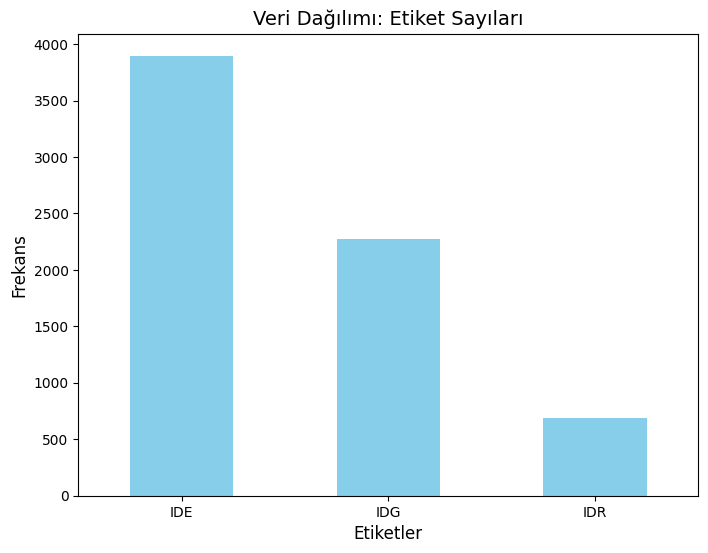

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Etikete göre verilerimin dağılımı
plt.figure(figsize=(8, 6))
final_df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Veri Dağılımı: Etiket Sayıları", fontsize=14)
plt.xlabel("Etiketler", fontsize=12)
plt.ylabel("Frekans", fontsize=12)
plt.xticks(rotation=0)
plt.show()

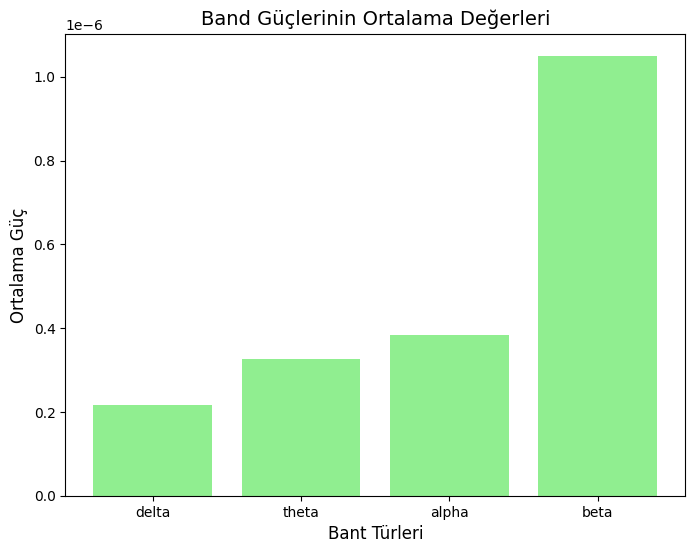

In [22]:
# Mean of band powers for each
bands = ['delta', 'theta', 'alpha', 'beta']
band_means = {band: final_df.filter(like=band).mean().mean() for band in bands}

plt.figure(figsize=(8, 6))
plt.bar(band_means.keys(), band_means.values(), color='lightgreen')
plt.title("Band Güçlerinin Ortalama Değerleri", fontsize=14)
plt.xlabel("Bant Türleri", fontsize=12)
plt.ylabel("Ortalama Güç", fontsize=12)
plt.show()


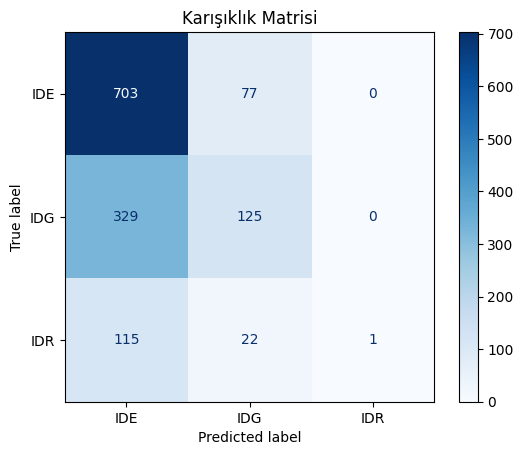

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Karışıklık Matrisi")
plt.show()

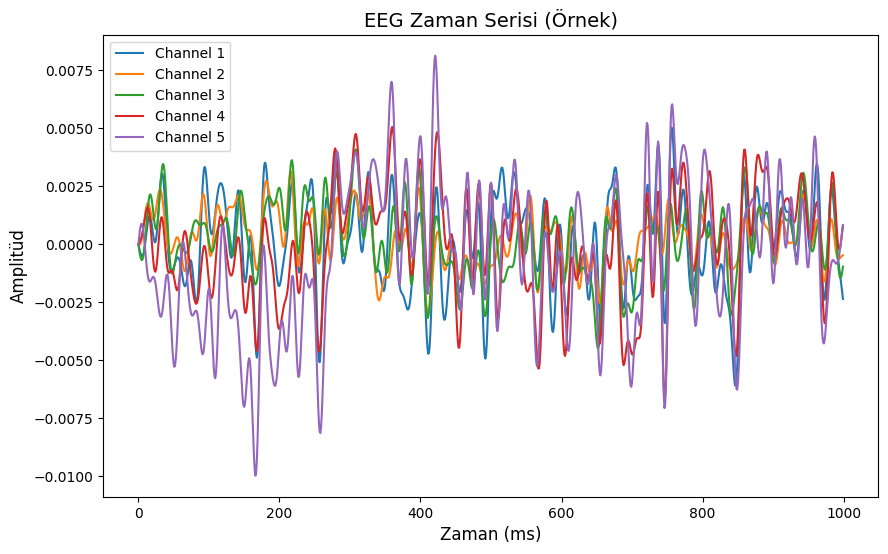

In [33]:
# EEG segment visualization example for 5 channels
sample_segment = data['Creativity_9_1_IDE'][:5, :1000]

plt.figure(figsize=(10, 6))
for i, channel_data in enumerate(sample_segment):
    plt.plot(channel_data, label=f"Channel {i+1}")

plt.title("EEG Zaman Serisi (Örnek)", fontsize=14)
plt.xlabel("Zaman (ms)", fontsize=12)
plt.ylabel("Amplitüd", fontsize=12)
plt.legend()
plt.show()

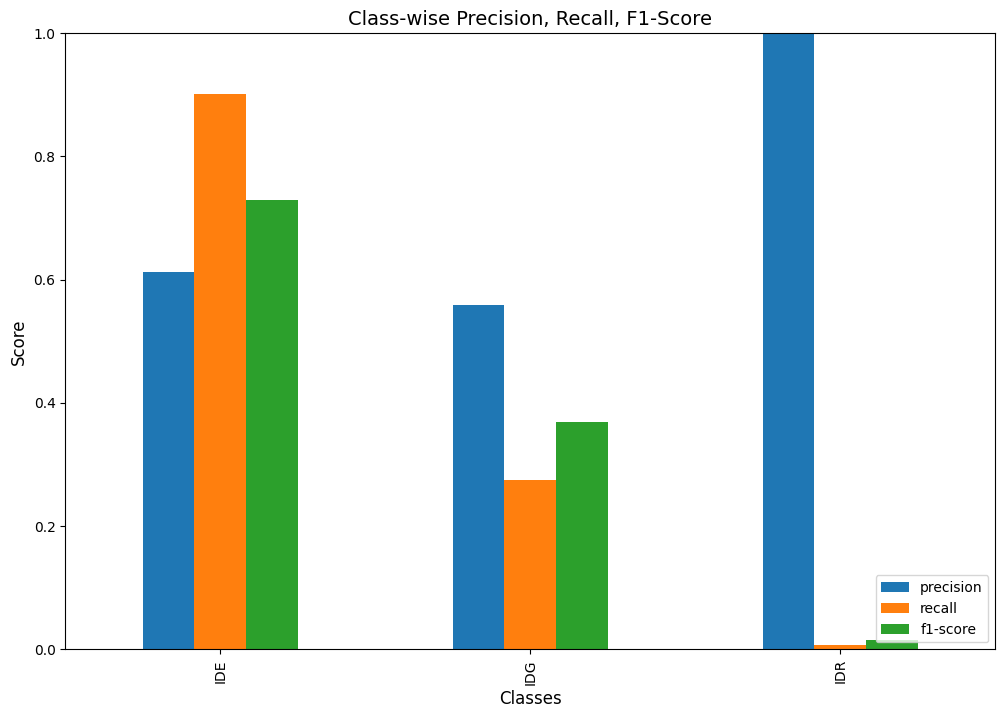

In [41]:
from sklearn.metrics import classification_report
import pandas as pd

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

class_metrics = report_df.iloc[:-3, :3]  # Precision, Recall, F1-score

# Visualization
class_metrics.plot(kind='bar', figsize=(12, 8))
plt.title("Class-wise Precision, Recall, F1-Score", fontsize=14)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)
plt.legend(loc='lower right', fontsize=10)
plt.show()


In [2]:
# Our hypothesis was to investigate, is there a significant difference between the EEG signals that we obtain while the person is  
# performing the tasks for the 3 different tasks? If we train a model, can that model use the difference between these classes to 
#prove which class an EEG signal belongs to? 

# According to the tests we did and the models we trained, we can say that the answer is yes.
#Because the tests we applied to the data showed that there is a significant difference between the classes and 
#that we can train a model that can predict 86%-90% using this difference.